In [1]:
import torch
from torch import nn
import torchvision

import Utils

In [2]:
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
X_DIM = 28
LATENT_DIM = 100
G_HIDDEN = 86
D_HIDDEN = 64
EPOCH_NUM = 100
lr_d = 0.00005
lr_g = 0.0001

In [3]:
device = Utils.get_device()
dataloader = Utils.get_loader(torchvision.datasets.MNIST, X_DIM, BATCH_SIZE)

Using device: cuda
Data loaded


## Sample images from the dataset

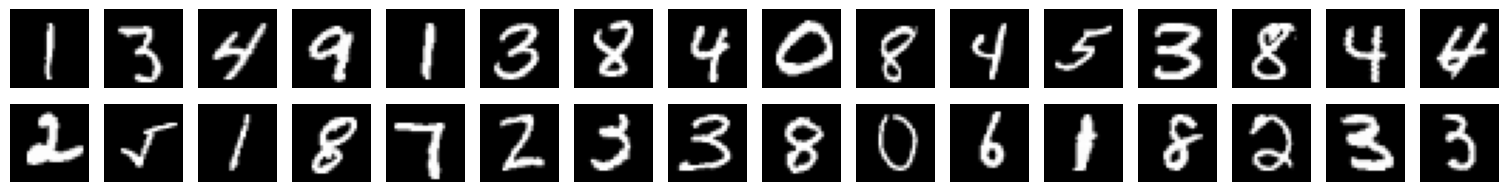

In [4]:
Utils.plot_real(dataloader)

## Model Architecture and Configuration

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0., 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(LATENT_DIM, G_HIDDEN * 4, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(inplace=True),  # shape: (G_HIDDEN * 4, 7, 7)
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(inplace=True),  # shape: (G_HIDDEN * 2, 14, 14)
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(inplace=True),  # shape: (G_HIDDEN, 28, 28)
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()  # shape: (IMAGE_CHANNEL, 28, 28)
        )

    def forward(self, x):
        return self.main(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),  # shape: (D_HIDDEN, 14, 14)
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),  # shape: (D_HIDDEN * 2, 7, 7)
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),  # shape: (D_HIDDEN * 4, 3, 3)
            # output layer
            nn.Conv2d(D_HIDDEN * 4, 1, kernel_size=3, stride=1, padding=0, bias=False),
            # shape: (1, 1, 1)
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

In [8]:
netG = Generator().to(device)
netG.apply(weights_init)
print('Number of parameters in the generator:', Utils.get_n_params(netG))

netD = Discriminator().to(device)
netD.apply(weights_init)
print('Number of parameters in the discriminator:', Utils.get_n_params(netD))

criterion = nn.BCEWithLogitsLoss()
viz_noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=device)

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(0.5, 0.999))

Number of parameters in the generator: 2870250
Number of parameters in the discriminator: 659456


## Training loop

[1/100][150/469]	Loss_D: 0.5530	Loss_G: 1.6225	D(x): 0.7582	D(G(z)): 0.2258 / 0.2097
[1/100][300/469]	Loss_D: 0.4438	Loss_G: 1.8178	D(x): 0.7870	D(G(z)): 0.1719 / 0.1784
[1/100][450/469]	Loss_D: 0.3348	Loss_G: 2.0597	D(x): 0.9206	D(G(z)): 0.2124 / 0.1476
[2/100][150/469]	Loss_D: 0.3018	Loss_G: 2.6719	D(x): 0.9154	D(G(z)): 0.1804 / 0.0847
[2/100][300/469]	Loss_D: 0.2759	Loss_G: 2.1525	D(x): 0.8324	D(G(z)): 0.0739 / 0.1451
[2/100][450/469]	Loss_D: 0.2815	Loss_G: 2.5904	D(x): 0.8699	D(G(z)): 0.1185 / 0.0975
[3/100][150/469]	Loss_D: 0.4223	Loss_G: 2.1066	D(x): 0.8523	D(G(z)): 0.2081 / 0.1527
[3/100][300/469]	Loss_D: 0.4276	Loss_G: 1.4744	D(x): 0.7604	D(G(z)): 0.1164 / 0.2754
[3/100][450/469]	Loss_D: 0.6458	Loss_G: 1.0916	D(x): 0.6063	D(G(z)): 0.0792 / 0.3890
[4/100][150/469]	Loss_D: 0.3670	Loss_G: 1.7616	D(x): 0.8092	D(G(z)): 0.1229 / 0.2066
[4/100][300/469]	Loss_D: 0.4999	Loss_G: 1.7950	D(x): 0.7997	D(G(z)): 0.2143 / 0.2012
[4/100][450/469]	Loss_D: 0.4819	Loss_G: 1.6813	D(x): 0.7619	D(G(z

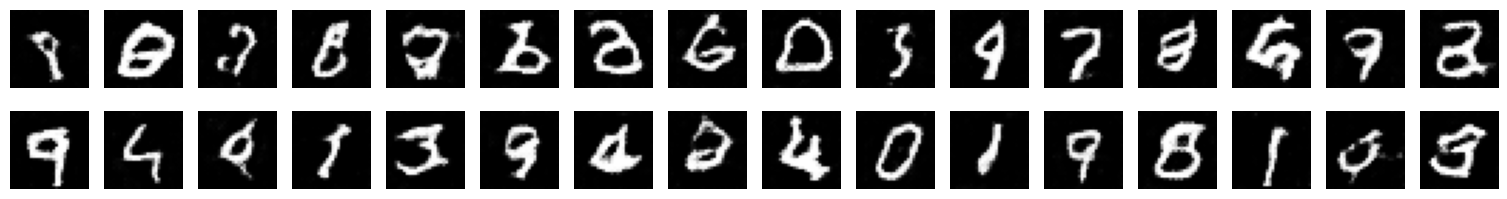

[6/100][150/469]	Loss_D: 0.6018	Loss_G: 1.8607	D(x): 0.7205	D(G(z)): 0.1988 / 0.1971
[6/100][300/469]	Loss_D: 0.4922	Loss_G: 1.4900	D(x): 0.7740	D(G(z)): 0.1797 / 0.2667
[6/100][450/469]	Loss_D: 0.5747	Loss_G: 2.0652	D(x): 0.7885	D(G(z)): 0.2540 / 0.1585
[7/100][150/469]	Loss_D: 0.5455	Loss_G: 2.2023	D(x): 0.6827	D(G(z)): 0.1102 / 0.1468
[7/100][300/469]	Loss_D: 0.5099	Loss_G: 2.1048	D(x): 0.8684	D(G(z)): 0.2830 / 0.1512
[7/100][450/469]	Loss_D: 0.3744	Loss_G: 2.1037	D(x): 0.8322	D(G(z)): 0.1585 / 0.1513
[8/100][150/469]	Loss_D: 0.6670	Loss_G: 1.7553	D(x): 0.5760	D(G(z)): 0.0567 / 0.2175
[8/100][300/469]	Loss_D: 0.6473	Loss_G: 2.6395	D(x): 0.9423	D(G(z)): 0.4091 / 0.0938
[8/100][450/469]	Loss_D: 0.5184	Loss_G: 1.9066	D(x): 0.8523	D(G(z)): 0.2779 / 0.1769
[9/100][150/469]	Loss_D: 0.4614	Loss_G: 1.9245	D(x): 0.7953	D(G(z)): 0.1817 / 0.1890
[9/100][300/469]	Loss_D: 0.5574	Loss_G: 2.0255	D(x): 0.8018	D(G(z)): 0.2473 / 0.1676
[9/100][450/469]	Loss_D: 0.6266	Loss_G: 1.1201	D(x): 0.6412	D(G(z

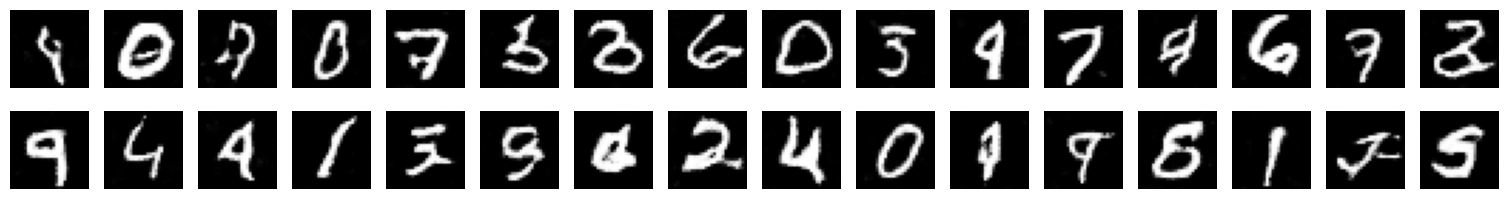

[11/100][150/469]	Loss_D: 0.4929	Loss_G: 1.7626	D(x): 0.7096	D(G(z)): 0.1126 / 0.2214
[11/100][300/469]	Loss_D: 0.4131	Loss_G: 1.8159	D(x): 0.7988	D(G(z)): 0.1525 / 0.2025
[11/100][450/469]	Loss_D: 0.4423	Loss_G: 1.9731	D(x): 0.8733	D(G(z)): 0.2375 / 0.1795
[12/100][150/469]	Loss_D: 0.3735	Loss_G: 2.2421	D(x): 0.8136	D(G(z)): 0.1312 / 0.1383
[12/100][300/469]	Loss_D: 0.5099	Loss_G: 1.6257	D(x): 0.7410	D(G(z)): 0.1544 / 0.2395
[12/100][450/469]	Loss_D: 0.5757	Loss_G: 1.6951	D(x): 0.8358	D(G(z)): 0.2940 / 0.2239
[13/100][150/469]	Loss_D: 0.5180	Loss_G: 2.0418	D(x): 0.8193	D(G(z)): 0.2415 / 0.1735
[13/100][300/469]	Loss_D: 0.4384	Loss_G: 2.1082	D(x): 0.8119	D(G(z)): 0.1870 / 0.1547
[13/100][450/469]	Loss_D: 0.3999	Loss_G: 1.9945	D(x): 0.7680	D(G(z)): 0.1054 / 0.1745
[14/100][150/469]	Loss_D: 1.5911	Loss_G: 0.4025	D(x): 0.2576	D(G(z)): 0.0230 / 0.7039
[14/100][300/469]	Loss_D: 0.6350	Loss_G: 2.4967	D(x): 0.9264	D(G(z)): 0.3989 / 0.1046
[14/100][450/469]	Loss_D: 0.4148	Loss_G: 1.7635	D(x): 

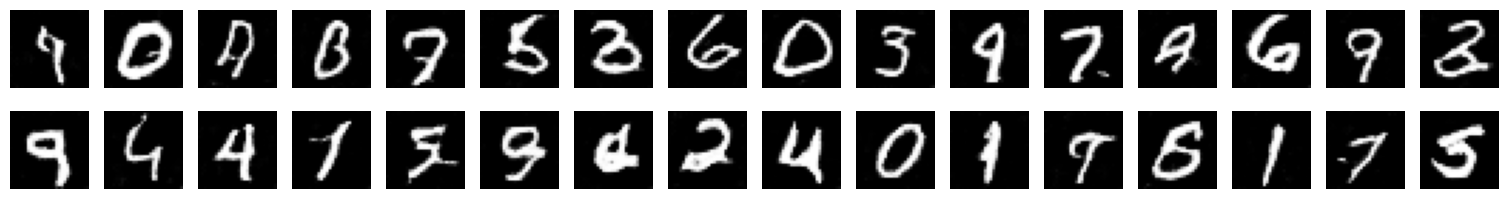

[16/100][150/469]	Loss_D: 0.4110	Loss_G: 2.3745	D(x): 0.8721	D(G(z)): 0.2163 / 0.1274
[16/100][300/469]	Loss_D: 0.5683	Loss_G: 2.6589	D(x): 0.8464	D(G(z)): 0.2961 / 0.0954
[16/100][450/469]	Loss_D: 0.5659	Loss_G: 2.0174	D(x): 0.8529	D(G(z)): 0.3024 / 0.1696
[17/100][150/469]	Loss_D: 0.4816	Loss_G: 1.9252	D(x): 0.7673	D(G(z)): 0.1641 / 0.1828
[17/100][300/469]	Loss_D: 0.4089	Loss_G: 2.3374	D(x): 0.7974	D(G(z)): 0.1481 / 0.1247
[17/100][450/469]	Loss_D: 0.4665	Loss_G: 1.7282	D(x): 0.7547	D(G(z)): 0.1433 / 0.2105
[18/100][150/469]	Loss_D: 0.5210	Loss_G: 1.6516	D(x): 0.8387	D(G(z)): 0.2641 / 0.2263
[18/100][300/469]	Loss_D: 0.6074	Loss_G: 1.2967	D(x): 0.6925	D(G(z)): 0.1755 / 0.3282
[18/100][450/469]	Loss_D: 0.4028	Loss_G: 2.7102	D(x): 0.9022	D(G(z)): 0.2398 / 0.0874
[19/100][150/469]	Loss_D: 0.6217	Loss_G: 1.3057	D(x): 0.6428	D(G(z)): 0.1080 / 0.3191
[19/100][300/469]	Loss_D: 0.4206	Loss_G: 1.6374	D(x): 0.7809	D(G(z)): 0.1401 / 0.2286
[19/100][450/469]	Loss_D: 0.3781	Loss_G: 2.2954	D(x): 

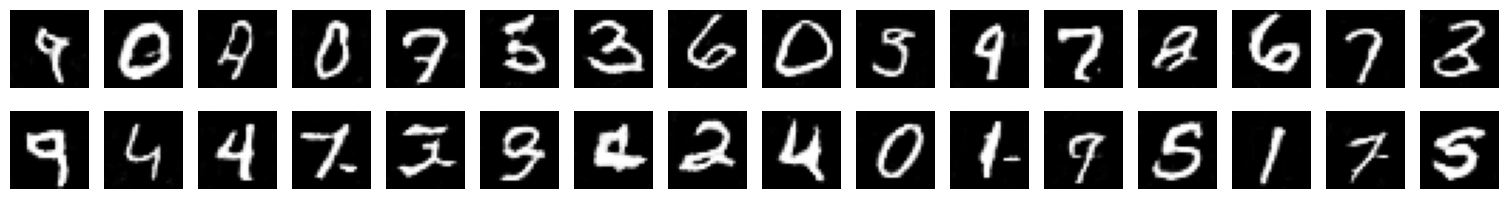

[21/100][150/469]	Loss_D: 0.5220	Loss_G: 2.2522	D(x): 0.6646	D(G(z)): 0.0667 / 0.1393
[21/100][300/469]	Loss_D: 0.5453	Loss_G: 2.1822	D(x): 0.8457	D(G(z)): 0.2826 / 0.1478
[21/100][450/469]	Loss_D: 0.5646	Loss_G: 1.2078	D(x): 0.6997	D(G(z)): 0.1469 / 0.3530
[22/100][150/469]	Loss_D: 0.5981	Loss_G: 2.2514	D(x): 0.8483	D(G(z)): 0.3146 / 0.1387
[22/100][300/469]	Loss_D: 0.6399	Loss_G: 2.5489	D(x): 0.8828	D(G(z)): 0.3646 / 0.1097
[22/100][450/469]	Loss_D: 0.4910	Loss_G: 1.5817	D(x): 0.7663	D(G(z)): 0.1703 / 0.2429
[23/100][150/469]	Loss_D: 0.4901	Loss_G: 2.2892	D(x): 0.8295	D(G(z)): 0.2360 / 0.1316
[23/100][300/469]	Loss_D: 0.5230	Loss_G: 2.5794	D(x): 0.8518	D(G(z)): 0.2778 / 0.0993
[23/100][450/469]	Loss_D: 0.4912	Loss_G: 2.3347	D(x): 0.7905	D(G(z)): 0.1929 / 0.1334
[24/100][150/469]	Loss_D: 0.4800	Loss_G: 2.2954	D(x): 0.7413	D(G(z)): 0.1361 / 0.1432
[24/100][300/469]	Loss_D: 0.3822	Loss_G: 2.0610	D(x): 0.8041	D(G(z)): 0.1317 / 0.1642
[24/100][450/469]	Loss_D: 0.7224	Loss_G: 2.0081	D(x): 

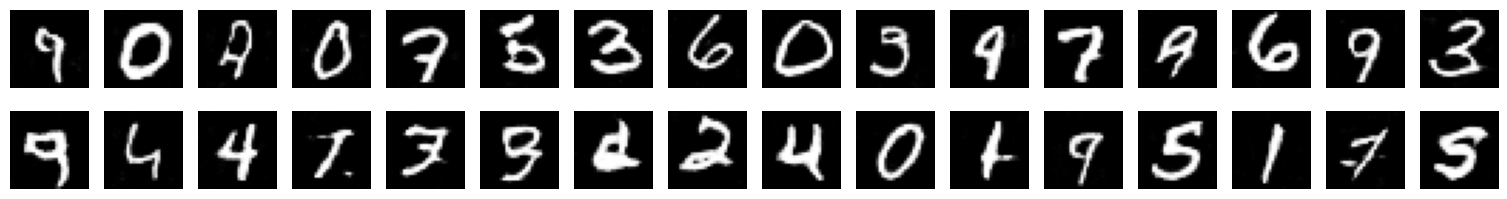

[26/100][150/469]	Loss_D: 0.4981	Loss_G: 2.2440	D(x): 0.7654	D(G(z)): 0.1755 / 0.1419
[26/100][300/469]	Loss_D: 0.4462	Loss_G: 2.0820	D(x): 0.8880	D(G(z)): 0.2547 / 0.1597
[26/100][450/469]	Loss_D: 0.6063	Loss_G: 2.5762	D(x): 0.8698	D(G(z)): 0.3377 / 0.1058
[27/100][150/469]	Loss_D: 0.4637	Loss_G: 1.8204	D(x): 0.7037	D(G(z)): 0.0769 / 0.2001
[27/100][300/469]	Loss_D: 0.4597	Loss_G: 2.3268	D(x): 0.8135	D(G(z)): 0.1959 / 0.1347
[27/100][450/469]	Loss_D: 0.6965	Loss_G: 1.1539	D(x): 0.6307	D(G(z)): 0.1546 / 0.3646
[28/100][150/469]	Loss_D: 0.9378	Loss_G: 2.9486	D(x): 0.9431	D(G(z)): 0.5218 / 0.0771
[28/100][300/469]	Loss_D: 0.4474	Loss_G: 2.0886	D(x): 0.9052	D(G(z)): 0.2705 / 0.1592
[28/100][450/469]	Loss_D: 0.4933	Loss_G: 1.7961	D(x): 0.7201	D(G(z)): 0.1212 / 0.2155
[29/100][150/469]	Loss_D: 0.3937	Loss_G: 2.7129	D(x): 0.8239	D(G(z)): 0.1617 / 0.0922
[29/100][300/469]	Loss_D: 0.4569	Loss_G: 1.8398	D(x): 0.7838	D(G(z)): 0.1658 / 0.1964
[29/100][450/469]	Loss_D: 0.7507	Loss_G: 0.8997	D(x): 

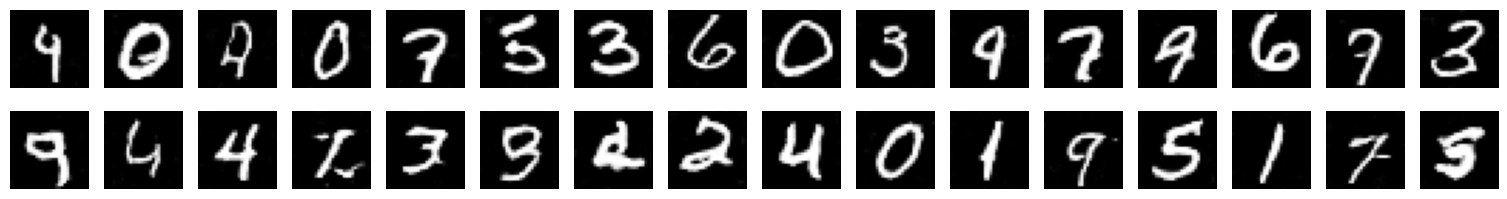

[31/100][150/469]	Loss_D: 0.7934	Loss_G: 1.2410	D(x): 0.5208	D(G(z)): 0.0635 / 0.3560
[31/100][300/469]	Loss_D: 0.3837	Loss_G: 2.0679	D(x): 0.8635	D(G(z)): 0.1896 / 0.1697
[31/100][450/469]	Loss_D: 0.7424	Loss_G: 2.9029	D(x): 0.8191	D(G(z)): 0.3648 / 0.0815
[32/100][150/469]	Loss_D: 0.5619	Loss_G: 2.1709	D(x): 0.7141	D(G(z)): 0.1644 / 0.1513
[32/100][300/469]	Loss_D: 0.4008	Loss_G: 2.6204	D(x): 0.8078	D(G(z)): 0.1504 / 0.1004
[32/100][450/469]	Loss_D: 0.6377	Loss_G: 1.8532	D(x): 0.5928	D(G(z)): 0.0481 / 0.2124
[33/100][150/469]	Loss_D: 0.4293	Loss_G: 1.5537	D(x): 0.7737	D(G(z)): 0.1346 / 0.2645
[33/100][300/469]	Loss_D: 0.6066	Loss_G: 2.5970	D(x): 0.9209	D(G(z)): 0.3680 / 0.1032
[33/100][450/469]	Loss_D: 0.7236	Loss_G: 2.9992	D(x): 0.9405	D(G(z)): 0.4382 / 0.0702
[34/100][150/469]	Loss_D: 0.3974	Loss_G: 2.9601	D(x): 0.7790	D(G(z)): 0.1067 / 0.0778
[34/100][300/469]	Loss_D: 0.6874	Loss_G: 0.9841	D(x): 0.5735	D(G(z)): 0.0680 / 0.4347
[34/100][450/469]	Loss_D: 0.4217	Loss_G: 1.5613	D(x): 

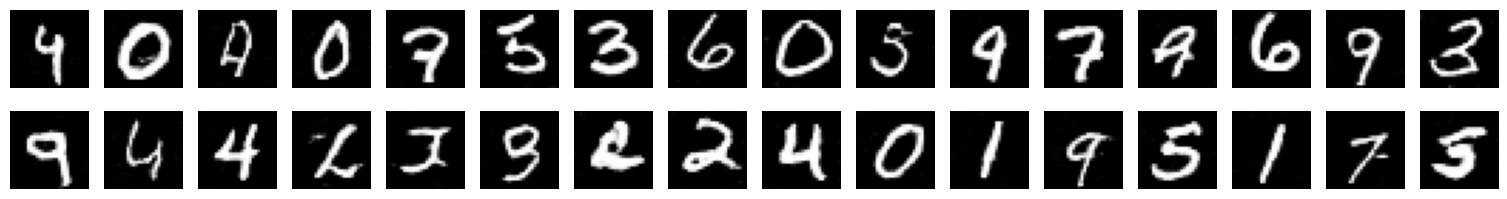

[36/100][150/469]	Loss_D: 0.3349	Loss_G: 3.1547	D(x): 0.9164	D(G(z)): 0.1996 / 0.0638
[36/100][300/469]	Loss_D: 0.6887	Loss_G: 1.7760	D(x): 0.5580	D(G(z)): 0.0387 / 0.2092
[36/100][450/469]	Loss_D: 0.4904	Loss_G: 2.0134	D(x): 0.8155	D(G(z)): 0.2254 / 0.1687
[37/100][150/469]	Loss_D: 0.5018	Loss_G: 1.8203	D(x): 0.6766	D(G(z)): 0.0741 / 0.2103
[37/100][300/469]	Loss_D: 0.4730	Loss_G: 2.0570	D(x): 0.7904	D(G(z)): 0.1816 / 0.1722
[37/100][450/469]	Loss_D: 0.5497	Loss_G: 1.5401	D(x): 0.6477	D(G(z)): 0.0673 / 0.2739
[38/100][150/469]	Loss_D: 0.5210	Loss_G: 1.3731	D(x): 0.6444	D(G(z)): 0.0383 / 0.3156
[38/100][300/469]	Loss_D: 0.4300	Loss_G: 2.2193	D(x): 0.7372	D(G(z)): 0.0888 / 0.1489
[38/100][450/469]	Loss_D: 0.6105	Loss_G: 1.2245	D(x): 0.6515	D(G(z)): 0.1214 / 0.3500
[39/100][150/469]	Loss_D: 0.4423	Loss_G: 2.3528	D(x): 0.8718	D(G(z)): 0.2390 / 0.1277
[39/100][300/469]	Loss_D: 0.6580	Loss_G: 2.8298	D(x): 0.9101	D(G(z)): 0.3814 / 0.0866
[39/100][450/469]	Loss_D: 0.5482	Loss_G: 1.5287	D(x): 

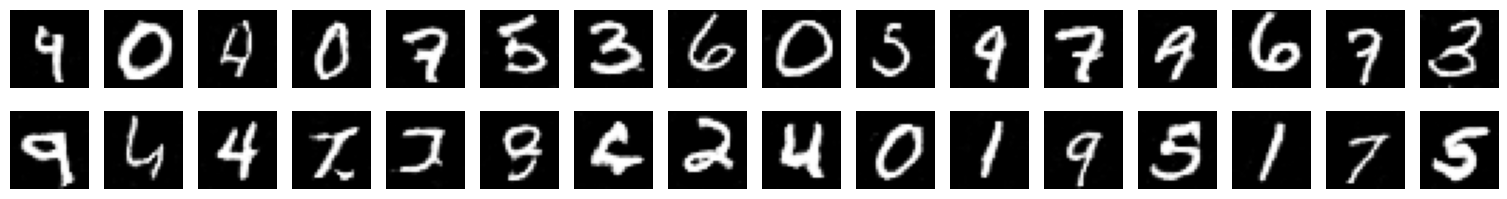

[41/100][150/469]	Loss_D: 0.4925	Loss_G: 2.3147	D(x): 0.7064	D(G(z)): 0.1011 / 0.1363
[41/100][300/469]	Loss_D: 0.5174	Loss_G: 2.5396	D(x): 0.6591	D(G(z)): 0.0610 / 0.1079
[41/100][450/469]	Loss_D: 0.3427	Loss_G: 2.3700	D(x): 0.7970	D(G(z)): 0.0926 / 0.1361
[42/100][150/469]	Loss_D: 0.4650	Loss_G: 1.5100	D(x): 0.7017	D(G(z)): 0.0656 / 0.2928
[42/100][300/469]	Loss_D: 0.7125	Loss_G: 1.6065	D(x): 0.6908	D(G(z)): 0.2407 / 0.2554
[42/100][450/469]	Loss_D: 0.4405	Loss_G: 2.2845	D(x): 0.6925	D(G(z)): 0.0331 / 0.1436
[43/100][150/469]	Loss_D: 0.3898	Loss_G: 2.3545	D(x): 0.8127	D(G(z)): 0.1488 / 0.1340
[43/100][300/469]	Loss_D: 0.6101	Loss_G: 1.4418	D(x): 0.6989	D(G(z)): 0.1806 / 0.2828
[43/100][450/469]	Loss_D: 0.4366	Loss_G: 2.7563	D(x): 0.8565	D(G(z)): 0.2222 / 0.0847
[44/100][150/469]	Loss_D: 0.4400	Loss_G: 2.2510	D(x): 0.8578	D(G(z)): 0.2248 / 0.1437
[44/100][300/469]	Loss_D: 0.4143	Loss_G: 2.8739	D(x): 0.8459	D(G(z)): 0.1972 / 0.0782
[44/100][450/469]	Loss_D: 0.3470	Loss_G: 1.9067	D(x): 

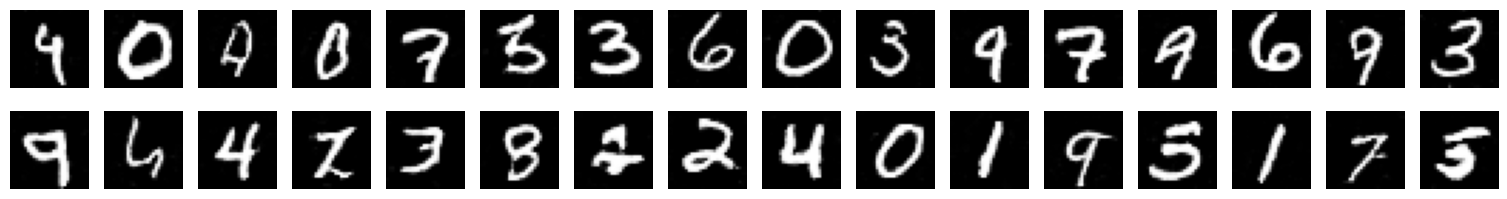

[46/100][150/469]	Loss_D: 0.4591	Loss_G: 2.5168	D(x): 0.8384	D(G(z)): 0.2241 / 0.1130
[46/100][300/469]	Loss_D: 0.4374	Loss_G: 1.9714	D(x): 0.7838	D(G(z)): 0.1547 / 0.1848
[46/100][450/469]	Loss_D: 0.3924	Loss_G: 2.1927	D(x): 0.8254	D(G(z)): 0.1575 / 0.1512
[47/100][150/469]	Loss_D: 0.5138	Loss_G: 2.7667	D(x): 0.9587	D(G(z)): 0.3425 / 0.0882
[47/100][300/469]	Loss_D: 0.7304	Loss_G: 1.7880	D(x): 0.5641	D(G(z)): 0.0792 / 0.2325
[47/100][450/469]	Loss_D: 0.9054	Loss_G: 2.2191	D(x): 0.8827	D(G(z)): 0.4806 / 0.1524
[48/100][150/469]	Loss_D: 0.3857	Loss_G: 2.5837	D(x): 0.9433	D(G(z)): 0.2461 / 0.1078
[48/100][300/469]	Loss_D: 0.6895	Loss_G: 1.1720	D(x): 0.5652	D(G(z)): 0.0572 / 0.3599
[48/100][450/469]	Loss_D: 0.5299	Loss_G: 1.9494	D(x): 0.8099	D(G(z)): 0.2387 / 0.1922
[49/100][150/469]	Loss_D: 0.3068	Loss_G: 2.4950	D(x): 0.8415	D(G(z)): 0.1070 / 0.1215
[49/100][300/469]	Loss_D: 0.4447	Loss_G: 2.0060	D(x): 0.8642	D(G(z)): 0.2220 / 0.1911
[49/100][450/469]	Loss_D: 0.7020	Loss_G: 4.0585	D(x): 

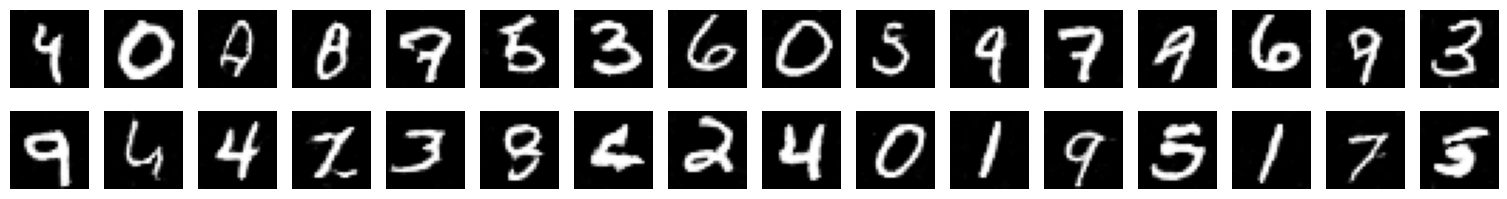

[51/100][150/469]	Loss_D: 0.3676	Loss_G: 2.9166	D(x): 0.8578	D(G(z)): 0.1740 / 0.0778
[51/100][300/469]	Loss_D: 0.8296	Loss_G: 2.9711	D(x): 0.9611	D(G(z)): 0.4889 / 0.0769
[51/100][450/469]	Loss_D: 0.3561	Loss_G: 2.8923	D(x): 0.8710	D(G(z)): 0.1786 / 0.0769
[52/100][150/469]	Loss_D: 0.5130	Loss_G: 2.9829	D(x): 0.9132	D(G(z)): 0.3107 / 0.0729
[52/100][300/469]	Loss_D: 0.6438	Loss_G: 1.7721	D(x): 0.8854	D(G(z)): 0.3689 / 0.2120
[52/100][450/469]	Loss_D: 0.6673	Loss_G: 1.3056	D(x): 0.5781	D(G(z)): 0.0469 / 0.3373
[53/100][150/469]	Loss_D: 0.3865	Loss_G: 2.6529	D(x): 0.8434	D(G(z)): 0.1758 / 0.0985
[53/100][300/469]	Loss_D: 0.5587	Loss_G: 3.2038	D(x): 0.9366	D(G(z)): 0.3542 / 0.0577
[53/100][450/469]	Loss_D: 0.3325	Loss_G: 2.4176	D(x): 0.7919	D(G(z)): 0.0774 / 0.1198
[54/100][150/469]	Loss_D: 0.4076	Loss_G: 2.2802	D(x): 0.7637	D(G(z)): 0.1058 / 0.1391
[54/100][300/469]	Loss_D: 0.3451	Loss_G: 2.0978	D(x): 0.7780	D(G(z)): 0.0707 / 0.1712
[54/100][450/469]	Loss_D: 0.6372	Loss_G: 2.2761	D(x): 

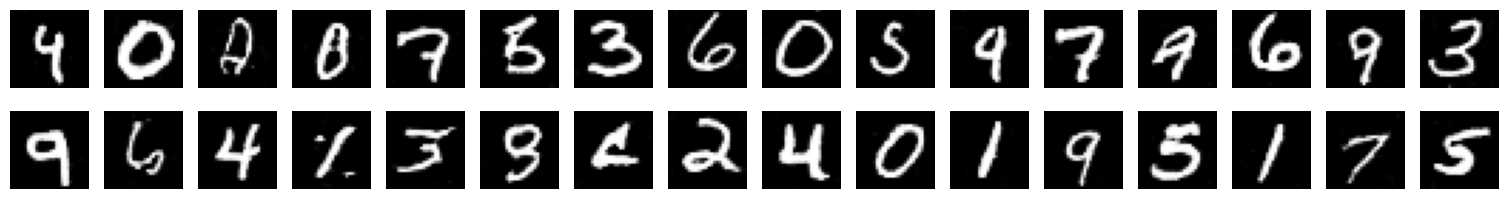

[56/100][150/469]	Loss_D: 0.5601	Loss_G: 2.2670	D(x): 0.8181	D(G(z)): 0.2564 / 0.1464
[56/100][300/469]	Loss_D: 0.5987	Loss_G: 2.1452	D(x): 0.7112	D(G(z)): 0.1892 / 0.1493
[56/100][450/469]	Loss_D: 0.4838	Loss_G: 2.5970	D(x): 0.9191	D(G(z)): 0.2977 / 0.1054
[57/100][150/469]	Loss_D: 0.8170	Loss_G: 0.9200	D(x): 0.5438	D(G(z)): 0.1110 / 0.4687
[57/100][300/469]	Loss_D: 0.6554	Loss_G: 2.8027	D(x): 0.8363	D(G(z)): 0.3267 / 0.0937
[57/100][450/469]	Loss_D: 0.7925	Loss_G: 2.5762	D(x): 0.9693	D(G(z)): 0.4672 / 0.1079
[58/100][150/469]	Loss_D: 0.4634	Loss_G: 2.1053	D(x): 0.7302	D(G(z)): 0.1017 / 0.1663
[58/100][300/469]	Loss_D: 0.4303	Loss_G: 1.7503	D(x): 0.7517	D(G(z)): 0.1064 / 0.2237
[58/100][450/469]	Loss_D: 0.4829	Loss_G: 3.2081	D(x): 0.7956	D(G(z)): 0.1841 / 0.0621
[59/100][150/469]	Loss_D: 0.2430	Loss_G: 3.5020	D(x): 0.8804	D(G(z)): 0.0989 / 0.0504
[59/100][300/469]	Loss_D: 0.4717	Loss_G: 2.9282	D(x): 0.7357	D(G(z)): 0.1133 / 0.0774
[59/100][450/469]	Loss_D: 0.3472	Loss_G: 1.7246	D(x): 

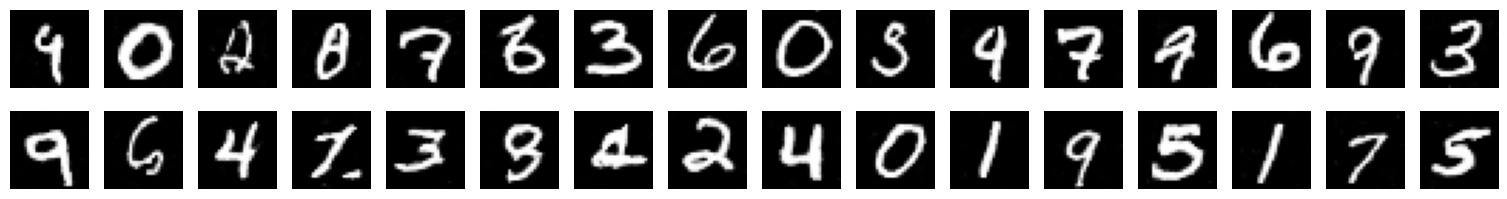

[61/100][150/469]	Loss_D: 0.5150	Loss_G: 1.7807	D(x): 0.7832	D(G(z)): 0.1917 / 0.2271
[61/100][300/469]	Loss_D: 0.4134	Loss_G: 2.6254	D(x): 0.8679	D(G(z)): 0.2125 / 0.1024
[61/100][450/469]	Loss_D: 0.3901	Loss_G: 2.8127	D(x): 0.8133	D(G(z)): 0.1374 / 0.0963
[62/100][150/469]	Loss_D: 0.3202	Loss_G: 3.0150	D(x): 0.9091	D(G(z)): 0.1801 / 0.0753
[62/100][300/469]	Loss_D: 0.4261	Loss_G: 2.0952	D(x): 0.8222	D(G(z)): 0.1835 / 0.1693
[62/100][450/469]	Loss_D: 0.7336	Loss_G: 2.6883	D(x): 0.9516	D(G(z)): 0.4335 / 0.0967
[63/100][150/469]	Loss_D: 0.6334	Loss_G: 2.2023	D(x): 0.9124	D(G(z)): 0.3730 / 0.1496
[63/100][300/469]	Loss_D: 0.4369	Loss_G: 2.2057	D(x): 0.8107	D(G(z)): 0.1715 / 0.1532
[63/100][450/469]	Loss_D: 0.4621	Loss_G: 1.6916	D(x): 0.7261	D(G(z)): 0.0988 / 0.2462
[64/100][150/469]	Loss_D: 0.3669	Loss_G: 2.0073	D(x): 0.7774	D(G(z)): 0.0889 / 0.1830
[64/100][300/469]	Loss_D: 0.4221	Loss_G: 3.1479	D(x): 0.9138	D(G(z)): 0.2555 / 0.0622
[64/100][450/469]	Loss_D: 0.3616	Loss_G: 2.8998	D(x): 

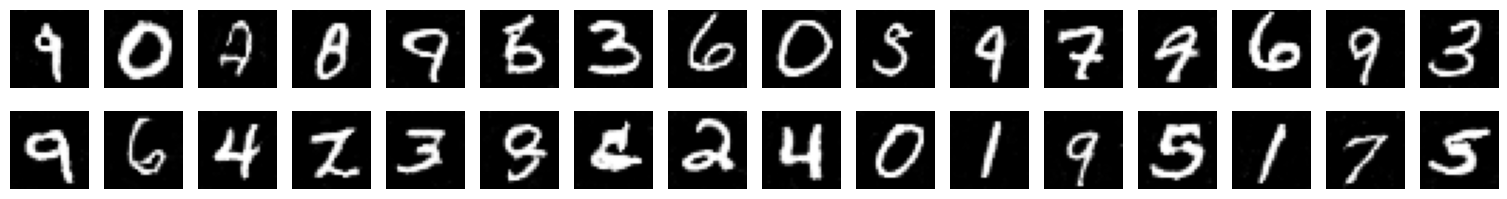

[66/100][150/469]	Loss_D: 0.4533	Loss_G: 1.9197	D(x): 0.7200	D(G(z)): 0.0871 / 0.2036
[66/100][300/469]	Loss_D: 0.3431	Loss_G: 2.0461	D(x): 0.8781	D(G(z)): 0.1712 / 0.1806
[66/100][450/469]	Loss_D: 0.2994	Loss_G: 2.4611	D(x): 0.8308	D(G(z)): 0.0923 / 0.1227
[67/100][150/469]	Loss_D: 0.4210	Loss_G: 2.5005	D(x): 0.8588	D(G(z)): 0.2100 / 0.1167
[67/100][300/469]	Loss_D: 0.5359	Loss_G: 2.0404	D(x): 0.6887	D(G(z)): 0.1124 / 0.1898
[67/100][450/469]	Loss_D: 0.4090	Loss_G: 2.2704	D(x): 0.8270	D(G(z)): 0.1700 / 0.1470
[68/100][150/469]	Loss_D: 0.4230	Loss_G: 3.5066	D(x): 0.8440	D(G(z)): 0.1882 / 0.0544
[68/100][300/469]	Loss_D: 0.4559	Loss_G: 2.9999	D(x): 0.8886	D(G(z)): 0.2541 / 0.0715
[68/100][450/469]	Loss_D: 0.4024	Loss_G: 2.1800	D(x): 0.8219	D(G(z)): 0.1658 / 0.1582
[69/100][150/469]	Loss_D: 0.3835	Loss_G: 1.9811	D(x): 0.8424	D(G(z)): 0.1630 / 0.1871
[69/100][300/469]	Loss_D: 0.3718	Loss_G: 2.9761	D(x): 0.8769	D(G(z)): 0.1951 / 0.0727
[69/100][450/469]	Loss_D: 0.5985	Loss_G: 1.5765	D(x): 

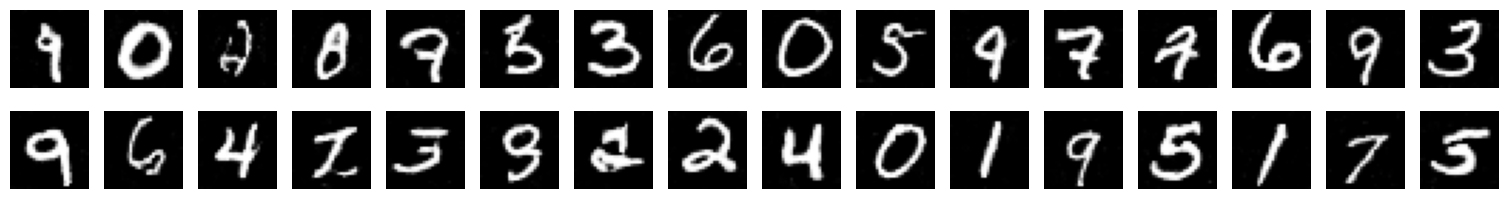

[71/100][150/469]	Loss_D: 0.7083	Loss_G: 2.2614	D(x): 0.9142	D(G(z)): 0.3978 / 0.1515
[71/100][300/469]	Loss_D: 0.6492	Loss_G: 1.3267	D(x): 0.6229	D(G(z)): 0.1035 / 0.3343
[71/100][450/469]	Loss_D: 0.3216	Loss_G: 2.5249	D(x): 0.8659	D(G(z)): 0.1439 / 0.1282
[72/100][150/469]	Loss_D: 0.8409	Loss_G: 1.0483	D(x): 0.4994	D(G(z)): 0.0518 / 0.4338
[72/100][300/469]	Loss_D: 0.5591	Loss_G: 1.1925	D(x): 0.6677	D(G(z)): 0.0966 / 0.3757
[72/100][450/469]	Loss_D: 0.5505	Loss_G: 3.4803	D(x): 0.9388	D(G(z)): 0.3415 / 0.0491
[73/100][150/469]	Loss_D: 0.3500	Loss_G: 2.9879	D(x): 0.9035	D(G(z)): 0.2019 / 0.0752
[73/100][300/469]	Loss_D: 0.5318	Loss_G: 2.5333	D(x): 0.8900	D(G(z)): 0.3090 / 0.1072
[73/100][450/469]	Loss_D: 0.3983	Loss_G: 1.8948	D(x): 0.7376	D(G(z)): 0.0610 / 0.2060
[74/100][150/469]	Loss_D: 0.6564	Loss_G: 1.2307	D(x): 0.5851	D(G(z)): 0.0361 / 0.3600
[74/100][300/469]	Loss_D: 0.3338	Loss_G: 2.9476	D(x): 0.8962	D(G(z)): 0.1800 / 0.0816
[74/100][450/469]	Loss_D: 0.3751	Loss_G: 2.2048	D(x): 

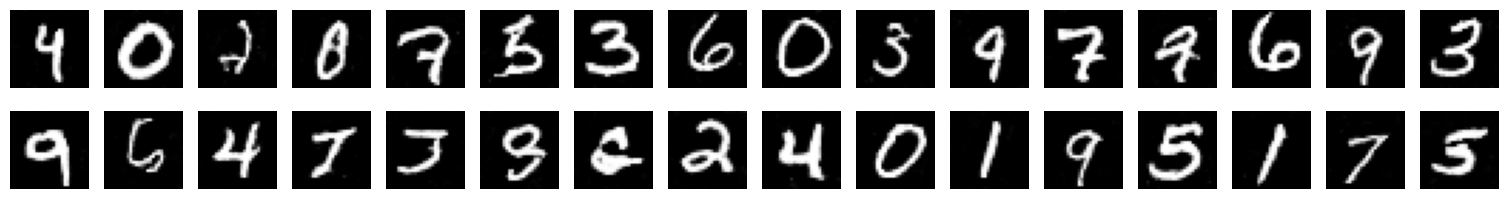

[76/100][150/469]	Loss_D: 0.2487	Loss_G: 3.0922	D(x): 0.9098	D(G(z)): 0.1288 / 0.0692
[76/100][300/469]	Loss_D: 0.4111	Loss_G: 2.5790	D(x): 0.8986	D(G(z)): 0.2355 / 0.1103
[76/100][450/469]	Loss_D: 0.4078	Loss_G: 1.7714	D(x): 0.8119	D(G(z)): 0.1561 / 0.2192
[77/100][150/469]	Loss_D: 0.5137	Loss_G: 2.1814	D(x): 0.8029	D(G(z)): 0.2190 / 0.1573
[77/100][300/469]	Loss_D: 0.3226	Loss_G: 2.3525	D(x): 0.8472	D(G(z)): 0.1270 / 0.1490
[77/100][450/469]	Loss_D: 0.4533	Loss_G: 2.8215	D(x): 0.8457	D(G(z)): 0.2203 / 0.0844
[78/100][150/469]	Loss_D: 0.3980	Loss_G: 1.4609	D(x): 0.7777	D(G(z)): 0.1107 / 0.3039
[78/100][300/469]	Loss_D: 0.4483	Loss_G: 2.0045	D(x): 0.8070	D(G(z)): 0.1717 / 0.1800
[78/100][450/469]	Loss_D: 0.5728	Loss_G: 2.7945	D(x): 0.8554	D(G(z)): 0.2965 / 0.0895
[79/100][150/469]	Loss_D: 0.6428	Loss_G: 2.7897	D(x): 0.8794	D(G(z)): 0.3585 / 0.0880
[79/100][300/469]	Loss_D: 0.3319	Loss_G: 2.3701	D(x): 0.7873	D(G(z)): 0.0644 / 0.1510
[79/100][450/469]	Loss_D: 0.5921	Loss_G: 2.4246	D(x): 

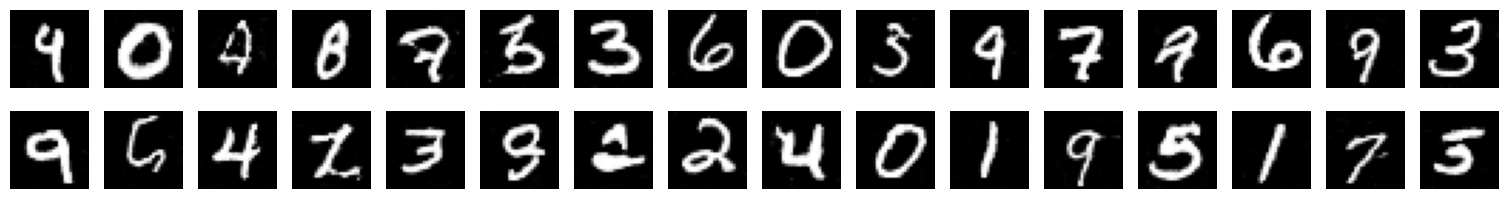

[81/100][150/469]	Loss_D: 0.6417	Loss_G: 1.4993	D(x): 0.6228	D(G(z)): 0.0984 / 0.2875
[81/100][300/469]	Loss_D: 0.4712	Loss_G: 3.1279	D(x): 0.8996	D(G(z)): 0.2761 / 0.0648
[81/100][450/469]	Loss_D: 0.5245	Loss_G: 3.3227	D(x): 0.9757	D(G(z)): 0.3548 / 0.0533
[82/100][150/469]	Loss_D: 0.4094	Loss_G: 2.3608	D(x): 0.7620	D(G(z)): 0.0906 / 0.1458
[82/100][300/469]	Loss_D: 0.4790	Loss_G: 2.9503	D(x): 0.7698	D(G(z)): 0.1584 / 0.0892
[82/100][450/469]	Loss_D: 0.4160	Loss_G: 1.5240	D(x): 0.7161	D(G(z)): 0.0467 / 0.2897
[83/100][150/469]	Loss_D: 0.3318	Loss_G: 2.1224	D(x): 0.8950	D(G(z)): 0.1835 / 0.1563
[83/100][300/469]	Loss_D: 0.3756	Loss_G: 2.5469	D(x): 0.9497	D(G(z)): 0.2440 / 0.1137
[83/100][450/469]	Loss_D: 0.4465	Loss_G: 2.1497	D(x): 0.8126	D(G(z)): 0.1858 / 0.1585
[84/100][150/469]	Loss_D: 0.3308	Loss_G: 2.4339	D(x): 0.8033	D(G(z)): 0.0839 / 0.1388
[84/100][300/469]	Loss_D: 0.4290	Loss_G: 2.9170	D(x): 0.9325	D(G(z)): 0.2782 / 0.0766
[84/100][450/469]	Loss_D: 0.3280	Loss_G: 2.5763	D(x): 

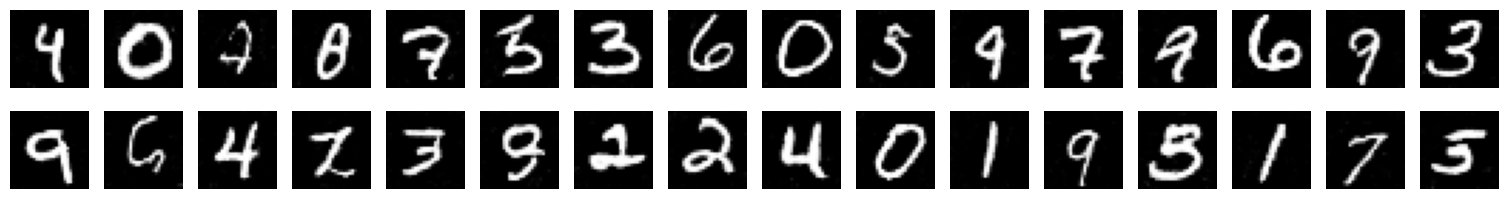

[86/100][150/469]	Loss_D: 0.3492	Loss_G: 2.3089	D(x): 0.8435	D(G(z)): 0.1405 / 0.1530
[86/100][300/469]	Loss_D: 0.3247	Loss_G: 2.5756	D(x): 0.8991	D(G(z)): 0.1753 / 0.1060
[86/100][450/469]	Loss_D: 0.6392	Loss_G: 1.6186	D(x): 0.5785	D(G(z)): 0.0271 / 0.2637
[87/100][150/469]	Loss_D: 0.3022	Loss_G: 2.5591	D(x): 0.8554	D(G(z)): 0.1169 / 0.1200
[87/100][300/469]	Loss_D: 0.3872	Loss_G: 1.7074	D(x): 0.7377	D(G(z)): 0.0509 / 0.2406
[87/100][450/469]	Loss_D: 0.4277	Loss_G: 1.7757	D(x): 0.7939	D(G(z)): 0.1493 / 0.2313
[88/100][150/469]	Loss_D: 0.3236	Loss_G: 3.2340	D(x): 0.8827	D(G(z)): 0.1643 / 0.0579
[88/100][300/469]	Loss_D: 0.5171	Loss_G: 2.9560	D(x): 0.9508	D(G(z)): 0.3336 / 0.0766
[88/100][450/469]	Loss_D: 0.1978	Loss_G: 3.2274	D(x): 0.8638	D(G(z)): 0.0414 / 0.0616
[89/100][150/469]	Loss_D: 0.4436	Loss_G: 2.0050	D(x): 0.7102	D(G(z)): 0.0648 / 0.2068
[89/100][300/469]	Loss_D: 0.5589	Loss_G: 1.4658	D(x): 0.7259	D(G(z)): 0.1705 / 0.2928
[89/100][450/469]	Loss_D: 0.3958	Loss_G: 2.0819	D(x): 

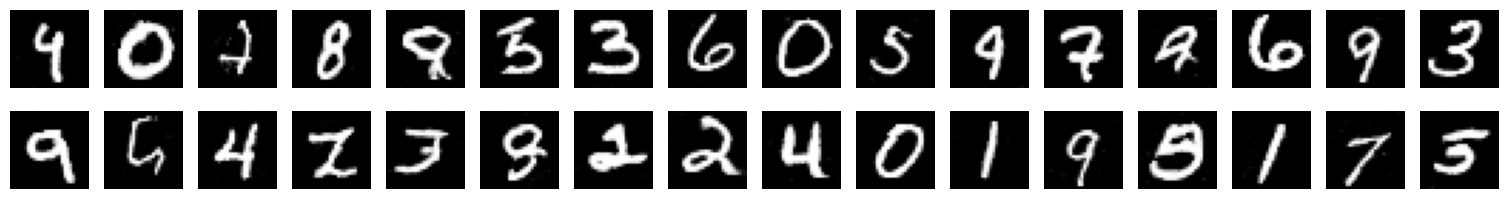

[91/100][150/469]	Loss_D: 0.8965	Loss_G: 3.3920	D(x): 0.9560	D(G(z)): 0.5026 / 0.0542
[91/100][300/469]	Loss_D: 1.7056	Loss_G: 2.7661	D(x): 0.9922	D(G(z)): 0.6927 / 0.1156
[91/100][450/469]	Loss_D: 0.5490	Loss_G: 3.5975	D(x): 0.9281	D(G(z)): 0.3377 / 0.0425
[92/100][150/469]	Loss_D: 0.3158	Loss_G: 2.8291	D(x): 0.9296	D(G(z)): 0.2004 / 0.0820
[92/100][300/469]	Loss_D: 0.4509	Loss_G: 2.5795	D(x): 0.7058	D(G(z)): 0.0563 / 0.1252
[92/100][450/469]	Loss_D: 0.2333	Loss_G: 2.7614	D(x): 0.8667	D(G(z)): 0.0735 / 0.0917
[93/100][150/469]	Loss_D: 0.3190	Loss_G: 2.6521	D(x): 0.8628	D(G(z)): 0.1340 / 0.1052
[93/100][300/469]	Loss_D: 0.3090	Loss_G: 2.5042	D(x): 0.8195	D(G(z)): 0.0878 / 0.1190
[93/100][450/469]	Loss_D: 0.5693	Loss_G: 3.4199	D(x): 0.8705	D(G(z)): 0.3072 / 0.0508
[94/100][150/469]	Loss_D: 0.3012	Loss_G: 2.8418	D(x): 0.8951	D(G(z)): 0.1594 / 0.0901
[94/100][300/469]	Loss_D: 0.5467	Loss_G: 2.9047	D(x): 0.9206	D(G(z)): 0.3271 / 0.0809
[94/100][450/469]	Loss_D: 0.6377	Loss_G: 1.2844	D(x): 

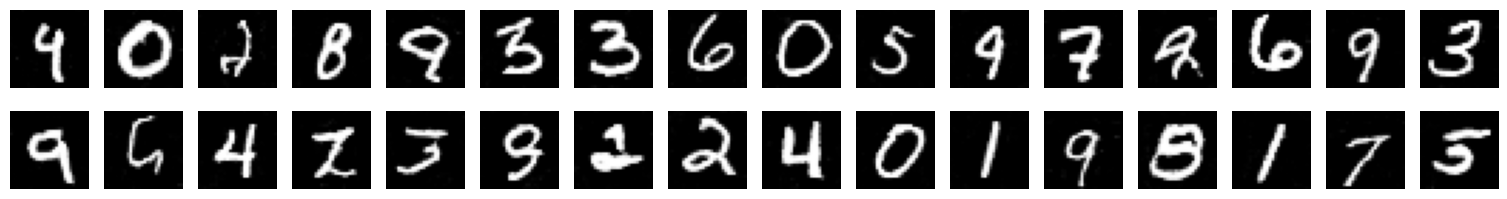

[96/100][150/469]	Loss_D: 0.8123	Loss_G: 4.4073	D(x): 0.9647	D(G(z)): 0.4778 / 0.0200
[96/100][300/469]	Loss_D: 0.4406	Loss_G: 1.7857	D(x): 0.8254	D(G(z)): 0.1913 / 0.2258
[96/100][450/469]	Loss_D: 0.5921	Loss_G: 4.0574	D(x): 0.9120	D(G(z)): 0.3462 / 0.0302
[97/100][150/469]	Loss_D: 0.3245	Loss_G: 2.9520	D(x): 0.9189	D(G(z)): 0.1901 / 0.0856
[97/100][300/469]	Loss_D: 0.4095	Loss_G: 2.0898	D(x): 0.8195	D(G(z)): 0.1637 / 0.1773
[97/100][450/469]	Loss_D: 0.5537	Loss_G: 2.0263	D(x): 0.6783	D(G(z)): 0.1021 / 0.1964
[98/100][150/469]	Loss_D: 0.3789	Loss_G: 2.9678	D(x): 0.8687	D(G(z)): 0.1818 / 0.0857
[98/100][300/469]	Loss_D: 0.3325	Loss_G: 2.2727	D(x): 0.8054	D(G(z)): 0.0904 / 0.1393
[98/100][450/469]	Loss_D: 0.4117	Loss_G: 2.1200	D(x): 0.8536	D(G(z)): 0.1889 / 0.1753
[99/100][150/469]	Loss_D: 0.2631	Loss_G: 2.5844	D(x): 0.8579	D(G(z)): 0.0897 / 0.1199
[99/100][300/469]	Loss_D: 0.7271	Loss_G: 1.7407	D(x): 0.5669	D(G(z)): 0.0641 / 0.2346
[99/100][450/469]	Loss_D: 0.3927	Loss_G: 2.9811	D(x): 

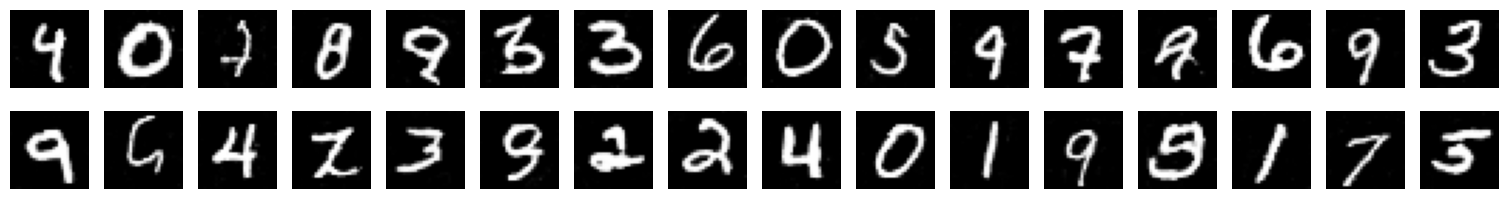

In [9]:
Utils.GAN_train(netD, netG, optimizerD, optimizerG, criterion, dataloader,
                EPOCH_NUM, X_DIM, LATENT_DIM, viz_noise, device)

## Sample fake images

fake images


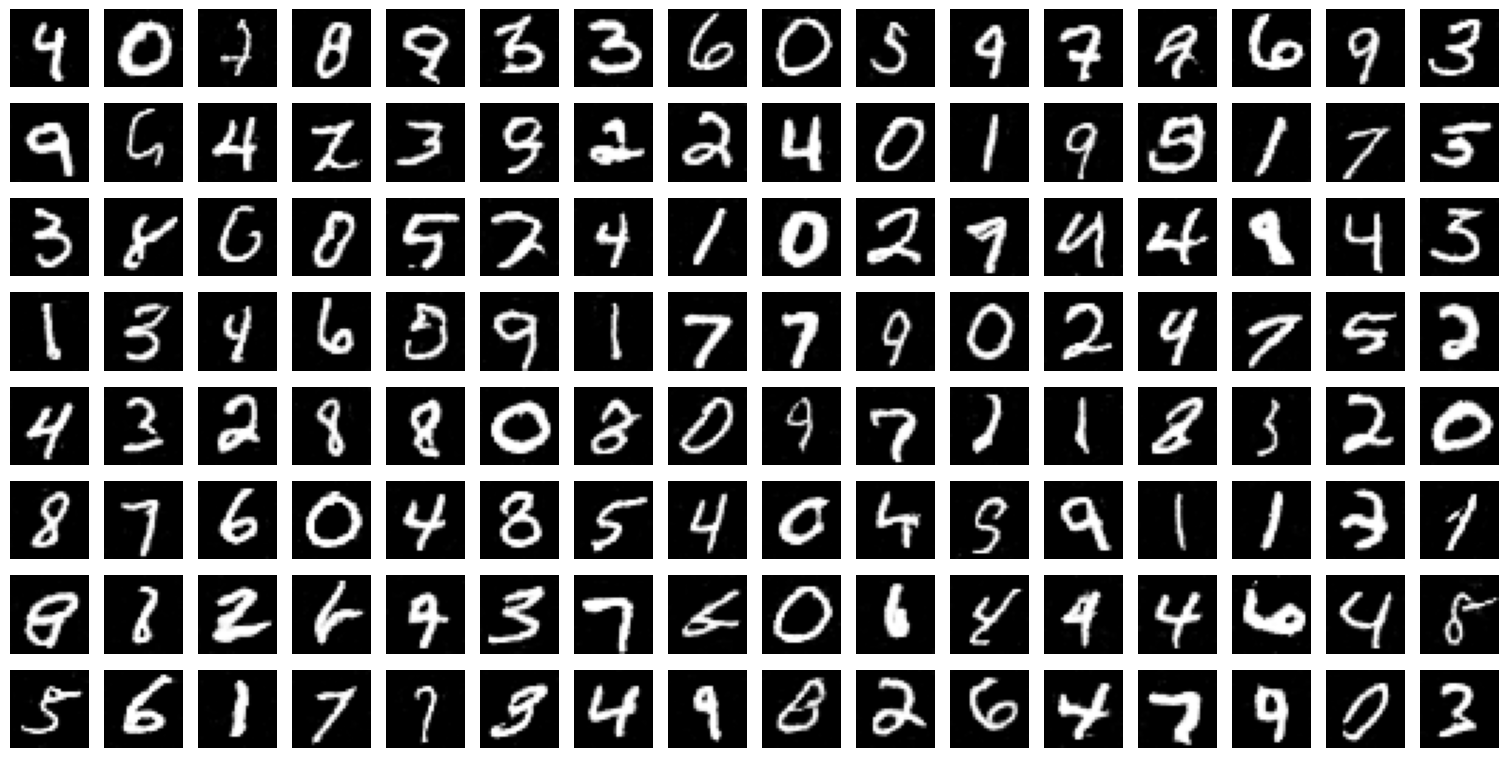

In [21]:
Utils.gan_plot_fake(netG, viz_noise, X_DIM, cnt=128)

## Saving the model

In [20]:
model = nn.Sequential(netG, nn.Upsample(size=56, mode='nearest'))  # Upsampling the images to 56x56
dummy_input = torch.randn(1, LATENT_DIM, 1, 1).to(device)
Utils.save_model(model, dummy_input, 'GAN_MNIST')